In [1]:
# Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

C:\Users\annek\AppData\Local\Temp\ipykernel_19408\33350407.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)


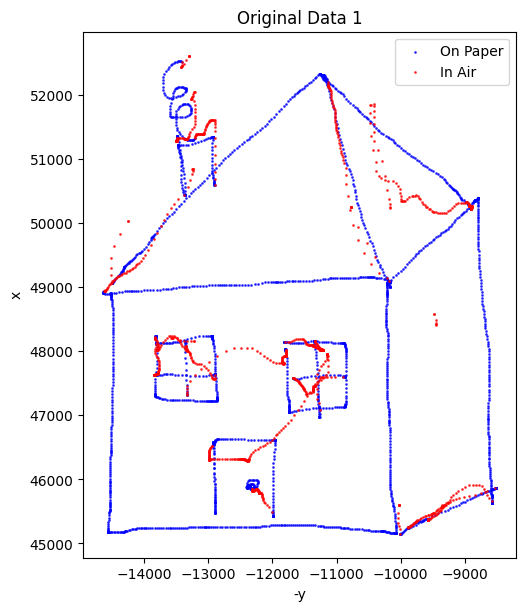

Processed data shape: (3386, 3)
Average number of data points: 3386


In [2]:
# Cell 2 (modified)
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    if num_files_to_use:
        svc_files = random.sample(svc_files, num_files_to_use)

    data_frames = []
    scalers = []

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        df = df.iloc[:, [0, 1, 3]]  # Select x, y, and pen_status
        data_frames.append(df)
        scaler = MinMaxScaler(feature_range=(-1, 1))  # Keep range (-1, 1)
        normalized_data = scaler.fit_transform(df[['x', 'y']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

    plt.show()

    combined_data = np.vstack([np.column_stack((scaler.transform(df[['x', 'y']]), df['pen_status'].values)) 
                               for df, scaler in zip(data_frames, scalers)])
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, combined_data, scalers, avg_data_points


directory = 'Task2'  # Directory where the .svc files are stored
data_frames, combined_data, scalers, avg_data_points = upload_and_process_files(directory, num_files_to_use=1)
print(f"Processed data shape: {combined_data.shape}")
print(f"Average number of data points: {avg_data_points}")


In [17]:
class LSTMDiscriminator(tf.keras.Model):
    def __init__(self, seq_length=100):
        super(LSTMDiscriminator, self).__init__()
        self.seq_length = seq_length
        self.lstm1 = tf.keras.layers.LSTM(64, return_sequences=True)  # Reduced units
        self.lstm2 = tf.keras.layers.LSTM(32)  # Reduced units
        self.dense1 = tf.keras.layers.Dense(16, activation='relu')  # Reduced units
        self.dense2 = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, x):
        x = tf.reshape(x, (-1, self.seq_length, 3))
        x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.dense1(x)
        return self.dense2(x)

class VAEGAN(tf.keras.Model):
    def __init__(self, latent_dim, beta=1.0, seq_length=100, discriminator_weight=0.1):
        super(VAEGAN, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta
        self.seq_length = seq_length
        self.discriminator_weight = discriminator_weight
        
        # Encoder (unchanged)
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(seq_length, 3)),
            tf.keras.layers.LSTM(256, return_sequences=True),
            tf.keras.layers.LSTM(128, return_sequences=True),
            tf.keras.layers.LSTM(64),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        
        # Decoder (unchanged)
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(64 * seq_length),
            tf.keras.layers.Reshape((seq_length, 64)),
            tf.keras.layers.LSTM(128, return_sequences=True),
            tf.keras.layers.LSTM(256, return_sequences=True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(3, activation='tanh'))
        ])
        
        # Discriminator (using the modified LSTMDiscriminator)
        self.discriminator = LSTMDiscriminator(seq_length)


    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        decoded = self.decoder(z)
        xy = tf.clip_by_value(decoded[:, :, :2], -1, 1)
        pen_status = tf.round(tf.sigmoid(decoded[:, :, 2]))
        return tf.concat([xy, tf.expand_dims(pen_status, -1)], axis=-1)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mean, logvar


In [18]:
# Cell 4
def compute_loss(vaegan, x):
    x_reconstructed, mean, logvar = vaegan(x)
    
    reconstruction_loss = tf.reduce_mean(tf.keras.losses.mse(x, x_reconstructed))
    kl_loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar), axis=1)
    kl_loss = tf.reduce_mean(kl_loss)

    real_output = vaegan.discriminator(x)
    fake_output = vaegan.discriminator(x_reconstructed)
    
    d_loss_real = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output))
    d_loss_fake = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output))
    g_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output))

    vae_loss = reconstruction_loss + vaegan.beta * kl_loss
    d_loss = d_loss_real + d_loss_fake
    total_loss = vae_loss + vaegan.discriminator_weight * (g_loss + d_loss)

    return total_loss, vae_loss, kl_loss, g_loss, d_loss

# Hyperparameters
latent_dim = 128
beta = 0.0001  # Reduced from 1
learning_rate = 0.001  # Further reduced
seq_length = 2
discriminator_weight = 0.001  # New hyperparameter to control discriminator's influence

vaegan = VAEGAN(latent_dim, beta, seq_length, discriminator_weight)
optimizer = tf.keras.optimizers.Adam(learning_rate)

In [19]:
# Cell 5 (modified)
def generate_augmented_data_vaegan(model, num_augmented_files, avg_data_points, variability=0.1):
    augmented_datasets = []
    
    for _ in range(num_augmented_files):
        # Generate random latent vectors
        z = tf.random.normal((avg_data_points // model.seq_length, model.latent_dim))
        # Decode to generate augmented data
        augmented_data = model.decode(z).numpy()

        # Flatten the sequence dimension
        augmented_data = augmented_data.reshape(-1, 3)

        # Determine the number of data points for this augmented dataset
        num_points = int(avg_data_points * (1 + variability * (random.random() - 0.5) * 2))
        
        # Truncate or pad the augmented data to match the number of data points
        if num_points < augmented_data.shape[0]:
            augmented_datasets.append(augmented_data[:num_points])
        else:
            padding = np.zeros((num_points - augmented_data.shape[0], augmented_data.shape[1]))
            augmented_datasets.append(np.vstack([augmented_data, padding]))

    return augmented_datasets



Epoch 1/500 started. Processing 4 batches...


Epoch 1/500:   0%|          | 0/4 [00:00<?, ?batch/s]

Starting train_step with input x shape: [512 2 3]
Losses - Total Loss: 0.399104476 VAE Loss: 0.397023678 KL Loss: 9.49733658e-05 Generator Loss: 0.693208575 Discriminator Loss: 1.3875922
Gradients before clipping: [0.000148125138,
 8.77259754e-06,
 5.34913415e-05,
 0.000137856157,
 6.01658485e-06,
 0.00021003437,
 9.5176918e-05,
 3.9097331e-06,
 0.000736238,
 8.06290191e-05,
 0.00288786623,
 0.00624745945,
 0.00271630893,
 0.0101138549,
 0.000573876081,
 0.00690338435,
 0.0131183229,
 0.000853006553,
 0.0535775423,
 0.00675746,
 0.122032501,
 4.75845627e-05,
 3.61472553e-06,
 5.63987232e-05,
 4.34593421e-05,
 2.16695071e-06,
 0.000195893284,
 1.7821405e-05,
 0.000377642456,
 1.73411645e-05,
 0.000500731054]
Gradients after clipping: [0.000148125138,
 8.77259754e-06,
 5.34913415e-05,
 0.000137856157,
 6.01658485e-06,
 0.00021003437,
 9.5176918e-05,
 3.9097331e-06,
 0.000736238,
 8.06290191e-05,
 0.00288786623,
 0.00624745945,
 0.00271630893,
 0.0101138549,
 0.000573876081,
 0.0069033843

Epoch 1/500:  25%|██▌       | 1/4 [00:28<01:26, 28.80s/batch, Total=0.399, VAE=0.397, KL=9.5e-5, G=0.693, D=1.39]

Starting train_step with input x shape: [512 2 3]
Losses - Total Loss: 0.405998737 VAE Loss: 0.403921694 KL Loss: 0.000200149778 Generator Loss: 0.689549267 Discriminator Loss: 1.38750315
Gradients before clipping: [0.000167106467,
 9.84696544e-06,
 4.23986457e-05,
 0.00015149641,
 6.6935836e-06,
 0.000158706651,
 9.94313232e-05,
 4.20292463e-06,
 0.000531397236,
 8.87839269e-05,
 0.00218384922,
 0.00680282712,
 0.00204226421,
 0.0109146489,
 0.000547588919,
 0.0053728926,
 0.0129860323,
 0.000777297188,
 0.0413237885,
 0.00640510069,
 0.094287008,
 5.06476972e-05,
 3.8641565e-06,
 5.99205123e-05,
 4.59609219e-05,
 2.26390489e-06,
 0.000205039774,
 1.84413329e-05,
 0.000390798319,
 1.7100725e-05,
 0.000495181361]
Gradients after clipping: [0.000167106467,
 9.84696544e-06,
 4.23986457e-05,
 0.00015149641,
 6.6935836e-06,
 0.000158706651,
 9.94313232e-05,
 4.20292463e-06,
 0.000531397236,
 8.87839269e-05,
 0.00218384922,
 0.00680282712,
 0.00204226421,
 0.0109146489,
 0.000547588919,
 0.

Epoch 1/500:  50%|█████     | 2/4 [00:29<00:24, 12.01s/batch, Total=0.406, VAE=0.404, KL=0.0002, G=0.69, D=1.39] 

Starting train_step with input x shape: [512 2 3]
Losses - Total Loss: 0.380035579 VAE Loss: 0.37796241 KL Loss: 0.000480934686 Generator Loss: 0.685319424 Discriminator Loss: 1.38783813
Gradients before clipping: [0.000185644749,
 1.09627017e-05,
 4.81089373e-05,
 0.000165984369,
 7.40627274e-06,
 0.000181765092,
 0.000108482156,
 5.09444726e-06,
 0.00060859,
 0.000104567065,
 0.0023376504,
 0.00733100763,
 0.00213595084,
 0.0110977134,
 0.000624648,
 0.00530714821,
 0.0147015583,
 0.000941828592,
 0.041388534,
 0.00730992062,
 0.0949963555,
 5.05789503e-05,
 3.86078091e-06,
 6.03065237e-05,
 4.48884275e-05,
 2.21165806e-06,
 0.000202638912,
 1.83161865e-05,
 0.000392602815,
 1.73232638e-05,
 0.000488942838]
Gradients after clipping: [0.000185644749,
 1.09627017e-05,
 4.81089373e-05,
 0.000165984369,
 7.40627274e-06,
 0.000181765092,
 0.000108482156,
 5.09444726e-06,
 0.00060859,
 0.000104567065,
 0.0023376504,
 0.00733100763,
 0.00213595084,
 0.0110977134,
 0.000624648,
 0.0053071482

Epoch 1/500:  75%|███████▌  | 3/4 [00:29<00:06,  6.65s/batch, Total=0.38, VAE=0.378, KL=0.000481, G=0.685, D=1.39]

Starting train_step with input x shape: [157 2 3]
Losses - Total Loss: 0.374129087 VAE Loss: 0.372060329 KL Loss: 0.000909406692 Generator Loss: 0.681254 Discriminator Loss: 1.38751352
Gradients before clipping: [0.000206221332,
 1.22973161e-05,
 4.56324851e-05,
 0.00018023148,
 8.34377533e-06,
 0.000161725,
 0.000119157114,
 6.14440296e-06,
 0.000521814858,
 0.000125400096,
 0.00201831548,
 0.013022203,
 0.00173932011,
 0.0166345462,
 0.000910281553,
 0.00417235633,
 0.0199134387,
 0.00129614049,
 0.0293604117,
 0.0100732483,
 0.0677493513,
 5.18029483e-05,
 4.00805311e-06,
 6.13753655e-05,
 4.58564864e-05,
 2.34260142e-06,
 0.000203262709,
 1.89015918e-05,
 0.000395048119,
 1.8932933e-05,
 0.00048257329]
Gradients after clipping: [0.000206221332,
 1.22973161e-05,
 4.56324851e-05,
 0.00018023148,
 8.34377533e-06,
 0.000161725,
 0.000119157114,
 6.14440296e-06,
 0.000521814858,
 0.000125400096,
 0.00201831548,
 0.013022203,
 0.00173932011,
 0.0166345462,
 0.000910281553,
 0.00417235633

Epoch 1/500: 100%|██████████| 4/4 [00:44<00:00, 11.03s/batch, Total=0.374, VAE=0.372, KL=0.000909, G=0.681, D=1.39]

Epoch 1/500 completed. Total Loss: 0.3898, Vae Loss: 0.3877, Kl Loss: 0.0004, G Loss: 0.6873, D Loss: 1.3876
New best loss achieved. Patience counter reset.
Generating and visualizing augmented data...


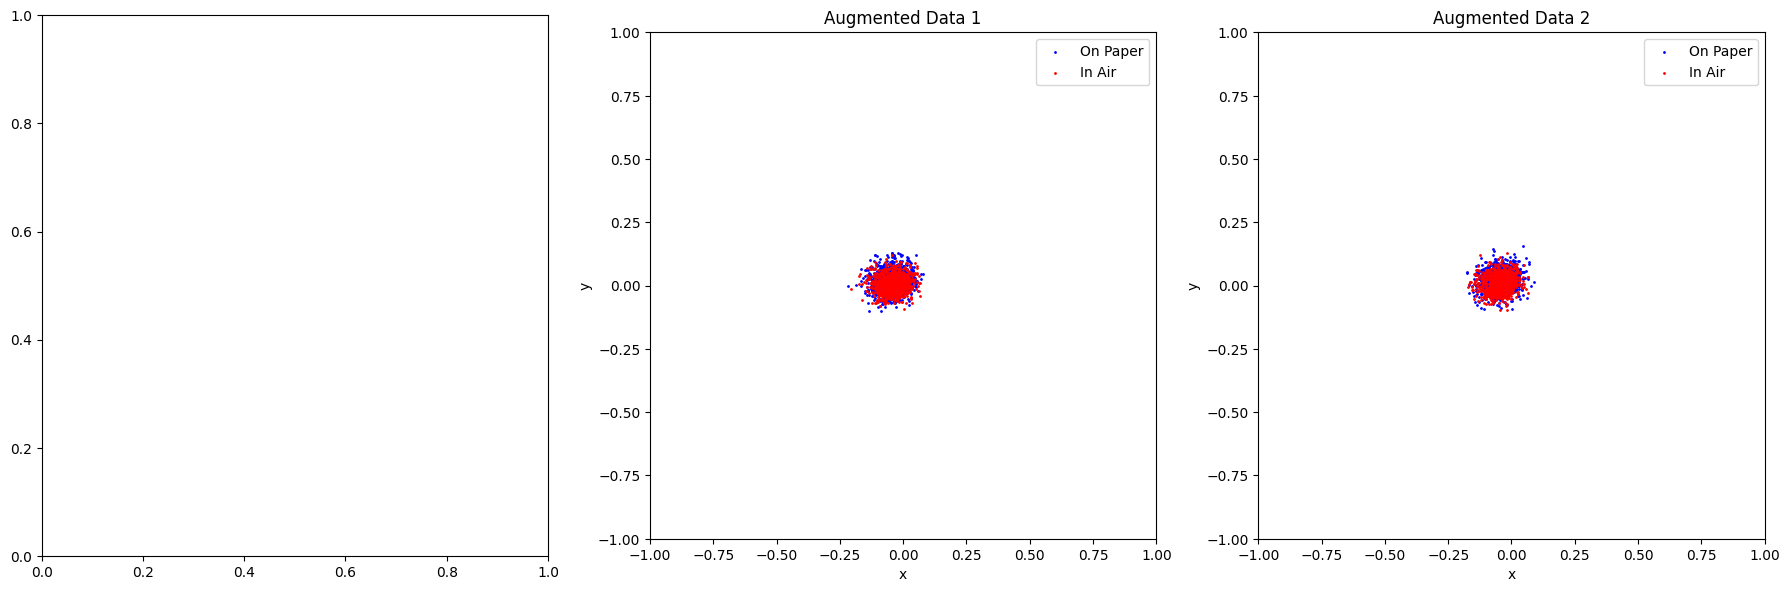


Epoch 2/500 started. Processing 4 batches...


Epoch 2/500:   0%|          | 0/4 [00:00<?, ?batch/s]

Starting train_step with input x shape: [512 2 3]
Losses - Total Loss: 0.376755595 VAE Loss: 0.374690384 KL Loss: 0.00149364502 Generator Loss: 0.676898658 Discriminator Loss: 1.38831973
Gradients before clipping: [0.000230252874,
 1.37261968e-05,
 5.58957181e-05,
 0.00020065633,
 9.45840202e-06,
 0.00019543129,
 0.00013658496,
 8.28824432e-06,
 0.000664980034,
 0.000155555055,
 0.00235423306,
 0.00754180225,
 0.00207658065,
 0.0102924211,
 0.000552675861,
 0.00485657575,
 0.012143027,
 0.000786414836,
 0.0343798734,
 0.00624197,
 0.0796402171,
 4.72008469e-05,
 3.62007722e-06,
 5.88547337e-05,
 4.05041319e-05,
 2.13108319e-06,
 0.000190412989,
 1.7514476e-05,
 0.000378907,
 2.00381182e-05,
 0.000476282701]
Gradients after clipping: [0.000230252874,
 1.37261968e-05,
 5.58957181e-05,
 0.00020065633,
 9.45840202e-06,
 0.00019543129,
 0.00013658496,
 8.28824432e-06,
 0.000664980034,
 0.000155555055,
 0.00235423306,
 0.00754180225,
 0.00207658065,
 0.0102924211,
 0.000552675861,
 0.0048565

Epoch 2/500:  25%|██▌       | 1/4 [00:00<00:00,  3.87batch/s, Total=0.377, VAE=0.375, KL=0.00149, G=0.677, D=1.39]

Starting train_step with input x shape: [512 2 3]
Losses - Total Loss: 0.383924156 VAE Loss: 0.381862938 KL Loss: 0.00223665265 Generator Loss: 0.672967792 Discriminator Loss: 1.38825405
Gradients before clipping: [0.000249014527,
 1.49405805e-05,
 5.78858417e-05,
 0.000217289708,
 1.05385752e-05,
 0.000208460217,
 0.000153787609,
 1.06050393e-05,
 0.00072893186,
 0.000189881946,
 0.00248698634,
 0.0080351,
 0.00212539,
 0.0107417749,
 0.000555104227,
 0.00485894782,
 0.0125042014,
 0.000827783078,
 0.0346821509,
 0.00681815762,
 0.0806585476,
 4.79370356e-05,
 3.66116365e-06,
 5.91173884e-05,
 4.01613215e-05,
 2.1848341e-06,
 0.00018817863,
 1.78956707e-05,
 0.000379667879,
 2.23808274e-05,
 0.000470158091]
Gradients after clipping: [0.000249014527,
 1.49405805e-05,
 5.78858417e-05,
 0.000217289708,
 1.05385752e-05,
 0.000208460217,
 0.000153787609,
 1.06050393e-05,
 0.00072893186,
 0.000189881946,
 0.00248698634,
 0.0080351,
 0.00212539,
 0.0107417749,
 0.000555104227,
 0.00485894782

Epoch 2/500:  50%|█████     | 2/4 [00:00<00:00,  4.27batch/s, Total=0.384, VAE=0.382, KL=0.00224, G=0.673, D=1.39]

Starting train_step with input x shape: [512 2 3]
Losses - Total Loss: 0.377864808 VAE Loss: 0.375807136 KL Loss: 0.0031584336 Generator Loss: 0.668857336 Discriminator Loss: 1.38882279
Gradients before clipping: [0.00027716966,
 1.66781483e-05,
 6.25586108e-05,
 0.000239825429,
 1.23067402e-05,
 0.000214554384,
 0.000179351278,
 1.32842915e-05,
 0.000710698368,
 0.000234017789,
 0.00245022657,
 0.00786455441,
 0.00204967661,
 0.0104747638,
 0.000550007855,
 0.00470251637,
 0.0120568806,
 0.000759232149,
 0.0314726345,
 0.00615222938,
 0.0733302683,
 4.56342714e-05,
 3.48406047e-06,
 6.03061926e-05,
 3.79659141e-05,
 2.20170273e-06,
 0.000190127394,
 1.77677284e-05,
 0.000384453218,
 2.46215859e-05,
 0.000464040902]
Gradients after clipping: [0.00027716966,
 1.66781483e-05,
 6.25586108e-05,
 0.000239825429,
 1.23067402e-05,
 0.000214554384,
 0.000179351278,
 1.32842915e-05,
 0.000710698368,
 0.000234017789,
 0.00245022657,
 0.00786455441,
 0.00204967661,
 0.0104747638,
 0.000550007855,

Epoch 2/500:  75%|███████▌  | 3/4 [00:00<00:00,  4.14batch/s, Total=0.378, VAE=0.376, KL=0.00316, G=0.669, D=1.39]

Starting train_step with input x shape: [157 2 3]
Losses - Total Loss: 0.382003129 VAE Loss: 0.379950255 KL Loss: 0.00422013877 Generator Loss: 0.665965378 Discriminator Loss: 1.38690472
Gradients before clipping: [0.000290753786,
 1.76912035e-05,
 4.4116674e-05,
 0.000247131102,
 1.31838415e-05,
 0.000157300936,
 0.000188340375,
 1.32002879e-05,
 0.000532106438,
 0.000236364416,
 0.00166383048,
 0.0147102587,
 0.0013096456,
 0.0219696555,
 0.00116407569,
 0.00326896179,
 0.0239795838,
 0.00159649306,
 0.0249048211,
 0.0121564129,
 0.0575836077,
 4.88993937e-05,
 3.7599093e-06,
 6.35507458e-05,
 4.00104145e-05,
 2.48449032e-06,
 0.000197197529,
 1.92606622e-05,
 0.000394404051,
 2.82953042e-05,
 0.00045852171]
Gradients after clipping: [0.000290753786,
 1.76912035e-05,
 4.4116674e-05,
 0.000247131102,
 1.31838415e-05,
 0.000157300936,
 0.000188340375,
 1.32002879e-05,
 0.000532106438,
 0.000236364416,
 0.00166383048,
 0.0147102587,
 0.0013096456,
 0.0219696555,
 0.00116407569,
 0.00326

Epoch 2/500: 100%|██████████| 4/4 [00:00<00:00,  4.57batch/s, Total=0.382, VAE=0.38, KL=0.00422, G=0.666, D=1.39] 

Epoch 2/500 completed. Total Loss: 0.3801, Vae Loss: 0.3781, Kl Loss: 0.0028, G Loss: 0.6712, D Loss: 1.3881
New best loss achieved. Patience counter reset.
Generating and visualizing augmented data...


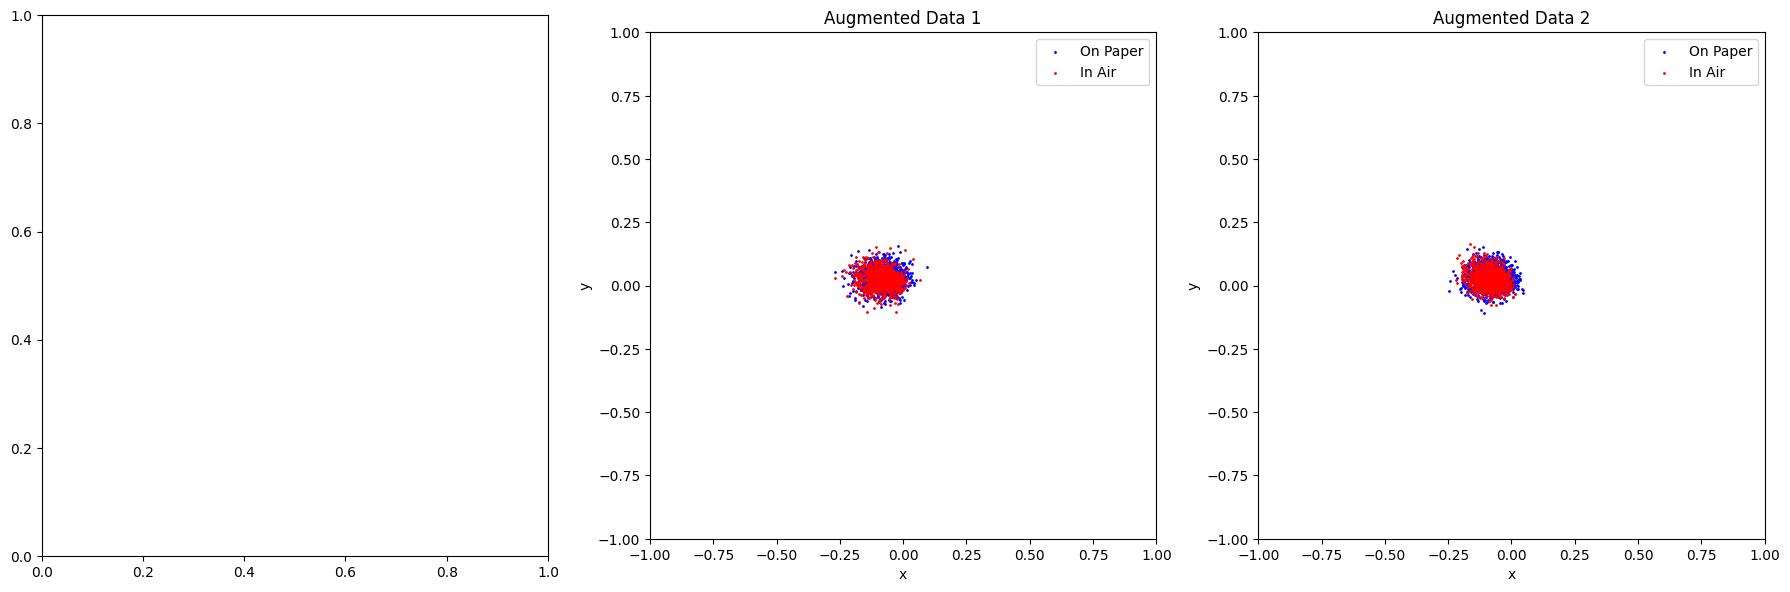


Epoch 3/500 started. Processing 4 batches...


Epoch 3/500:   0%|          | 0/4 [00:00<?, ?batch/s]

Starting train_step with input x shape: [512 2 3]
Losses - Total Loss: 0.385264724 VAE Loss: 0.38321498 KL Loss: 0.00560180889 Generator Loss: 0.661935687 Discriminator Loss: 1.38779366
Gradients before clipping: [0.00030940352,
 1.87409332e-05,
 6.91162422e-05,
 0.000259707915,
 1.49685166e-05,
 0.000227711091,
 0.000218046742,
 1.89272123e-05,
 0.000790328952,
 0.000301121647,
 0.00241828593,
 0.00756132789,
 0.00208497024,
 0.0102075748,
 0.00057681,
 0.00479642,
 0.0117243798,
 0.000835098559,
 0.0315485857,
 0.00694474811,
 0.0742164701,
 4.90377715e-05,
 3.74312231e-06,
 6.17914193e-05,
 3.98606389e-05,
 2.53610028e-06,
 0.000191479514,
 1.98689286e-05,
 0.000387114647,
 3.08314557e-05,
 0.00045261209]
Gradients after clipping: [0.00030940352,
 1.87409332e-05,
 6.91162422e-05,
 0.000259707915,
 1.49685166e-05,
 0.000227711091,
 0.000218046742,
 1.89272123e-05,
 0.000790328952,
 0.000301121647,
 0.00241828593,
 0.00756132789,
 0.00208497024,
 0.0102075748,
 0.00057681,
 0.00479642

Epoch 3/500:  25%|██▌       | 1/4 [00:00<00:00,  4.11batch/s, Total=0.385, VAE=0.383, KL=0.0056, G=0.662, D=1.39]

Starting train_step with input x shape: [512 2 3]
Losses - Total Loss: 0.383647799 VAE Loss: 0.38160181 KL Loss: 0.00707376376 Generator Loss: 0.658745 Discriminator Loss: 1.38725376
Gradients before clipping: [0.000310415693,
 1.88728118e-05,
 6.2388579e-05,
 0.000255962164,
 1.56450442e-05,
 0.000194395936,
 0.000226501841,
 1.96616329e-05,
 0.000614733144,
 0.000317057449,
 0.00195344118,
 0.00791944284,
 0.00166657742,
 0.0103727216,
 0.000532569364,
 0.00402792543,
 0.0109598832,
 0.0007293495,
 0.0257748812,
 0.00642769039,
 0.0604304522,
 4.73935179e-05,
 3.64653101e-06,
 6.338815e-05,
 3.85128806e-05,
 2.68241411e-06,
 0.00019480694,
 2.04998705e-05,
 0.000389882567,
 3.36113917e-05,
 0.000447256753]
Gradients after clipping: [0.000310415693,
 1.88728118e-05,
 6.2388579e-05,
 0.000255962164,
 1.56450442e-05,
 0.000194395936,
 0.000226501841,
 1.96616329e-05,
 0.000614733144,
 0.000317057449,
 0.00195344118,
 0.00791944284,
 0.00166657742,
 0.0103727216,
 0.000532569364,
 0.0040

Epoch 3/500:  50%|█████     | 2/4 [00:00<00:00,  4.39batch/s, Total=0.384, VAE=0.382, KL=0.00707, G=0.659, D=1.39]

Starting train_step with input x shape: [512 2 3]
Losses - Total Loss: 0.38816905 VAE Loss: 0.386127025 KL Loss: 0.00869777612 Generator Loss: 0.654046357 Discriminator Loss: 1.38796902
Gradients before clipping: [0.000360949343,
 2.2117747e-05,
 2.85470524e-05,
 0.000289930147,
 1.82292097e-05,
 7.67221791e-05,
 0.000254529,
 1.95724988e-05,
 0.000242983733,
 0.000338490267,
 0.000789051934,
 0.0083412379,
 0.000611288589,
 0.0124232331,
 0.000731946609,
 0.001237366,
 0.0146751301,
 0.000995945302,
 0.009859493,
 0.00760220131,
 0.025269242,
 4.48699539e-05,
 3.47402511e-06,
 6.38406636e-05,
 3.65830747e-05,
 2.84548946e-06,
 0.000195101922,
 2.11636943e-05,
 0.000385482592,
 3.65365049e-05,
 0.000440108939]
Gradients after clipping: [0.000360949343,
 2.2117747e-05,
 2.85470524e-05,
 0.000289930147,
 1.82292097e-05,
 7.67221791e-05,
 0.000254529,
 1.95724988e-05,
 0.000242983733,
 0.000338490267,
 0.000789051934,
 0.0083412379,
 0.000611288589,
 0.0124232331,
 0.000731946609,
 0.0012

Epoch 3/500:  75%|███████▌  | 3/4 [00:00<00:00,  4.03batch/s, Total=0.388, VAE=0.386, KL=0.0087, G=0.654, D=1.39] 

Starting train_step with input x shape: [157 2 3]
Losses - Total Loss: 0.361519098 VAE Loss: 0.359481663 KL Loss: 0.0105415257 Generator Loss: 0.6507 Discriminator Loss: 1.38674808
Gradients before clipping: [0.0003523411,
 2.12923314e-05,
 6.71731395e-05,
 0.000274937134,
 1.77521852e-05,
 0.000208781566,
 0.000257821928,
 2.19009489e-05,
 0.000661584723,
 0.000349986745,
 0.00207531219,
 0.0143924179,
 0.00168491749,
 0.0184275974,
 0.000958821038,
 0.00380508159,
 0.0203764122,
 0.00134083687,
 0.0291058477,
 0.0109585673,
 0.0650673,
 4.82504038e-05,
 3.70251223e-06,
 6.50871079e-05,
 3.87402979e-05,
 3.15133843e-06,
 0.000197374306,
 2.31981176e-05,
 0.000385166117,
 4.03836275e-05,
 0.000434074114]
Gradients after clipping: [0.0003523411,
 2.12923314e-05,
 6.71731395e-05,
 0.000274937134,
 1.77521852e-05,
 0.000208781566,
 0.000257821928,
 2.19009489e-05,
 0.000661584723,
 0.000349986745,
 0.00207531219,
 0.0143924179,
 0.00168491749,
 0.0184275974,
 0.000958821038,
 0.0038050815

Epoch 3/500: 100%|██████████| 4/4 [00:00<00:00,  4.58batch/s, Total=0.362, VAE=0.359, KL=0.0105, G=0.651, D=1.39]

Epoch 3/500 completed. Total Loss: 0.3797, Vae Loss: 0.3776, Kl Loss: 0.0080, G Loss: 0.6564, D Loss: 1.3874
New best loss achieved. Patience counter reset.
Generating and visualizing augmented data...


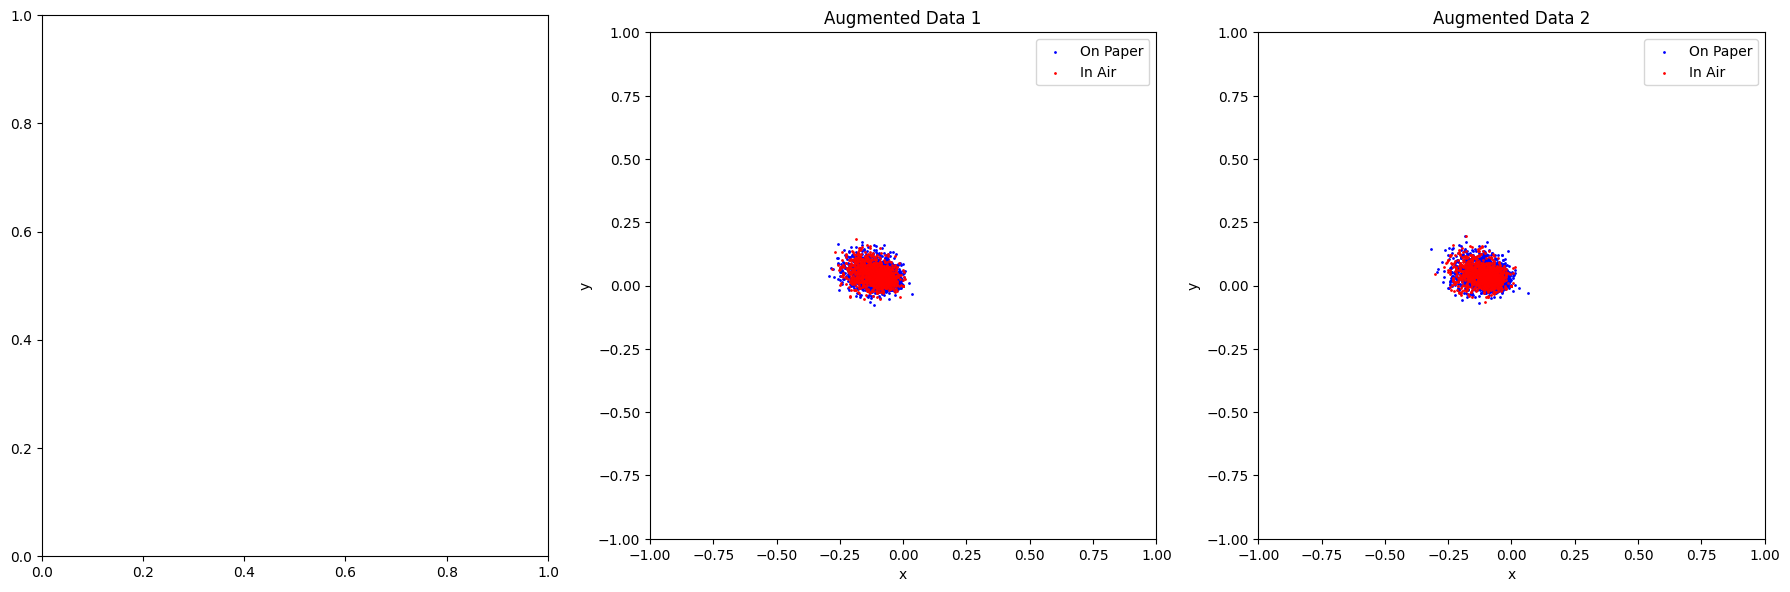


Epoch 4/500 started. Processing 4 batches...


Epoch 4/500:   0%|          | 0/4 [00:00<?, ?batch/s]

Starting train_step with input x shape: [512 2 3]
Losses - Total Loss: 0.371869862 VAE Loss: 0.369835556 KL Loss: 0.013016412 Generator Loss: 0.645434618 Discriminator Loss: 1.38887286
Gradients before clipping: [0.000405374187,
 2.4948331e-05,
 4.48274295e-05,
 0.000309502415,
 2.21287919e-05,
 0.000116023941,
 0.00030809702,
 2.70305482e-05,
 0.000340834202,
 0.000436699484,
 0.00107597187,
 0.00881731696,
 0.000931858318,
 0.0125209382,
 0.000698810094,
 0.00225818274,
 0.0133937718,
 0.000896988204,
 0.0141154891,
 0.00683508,
 0.0361385196,
 4.75099514e-05,
 3.66279642e-06,
 6.58616918e-05,
 3.79912526e-05,
 3.25894052e-06,
 0.000197558373,
 2.38927259e-05,
 0.000385035295,
 4.27142513e-05,
 0.000426644983]
Gradients after clipping: [0.000405374187,
 2.4948331e-05,
 4.48274295e-05,
 0.000309502415,
 2.21287919e-05,
 0.000116023941,
 0.00030809702,
 2.70305482e-05,
 0.000340834202,
 0.000436699484,
 0.00107597187,
 0.00881731696,
 0.000931858318,
 0.0125209382,
 0.000698810094,
 0.

Epoch 4/500:  25%|██▌       | 1/4 [00:00<00:00,  3.67batch/s, Total=0.372, VAE=0.37, KL=0.013, G=0.645, D=1.39]

Starting train_step with input x shape: [512 2 3]
Losses - Total Loss: 0.373744845 VAE Loss: 0.37171486 KL Loss: 0.0152848661 Generator Loss: 0.641632378 Discriminator Loss: 1.38834953
Gradients before clipping: [0.000452400622,
 2.82216042e-05,
 3.28079e-05,
 0.000334390614,
 2.5011459e-05,
 6.51970622e-05,
 0.000338042475,
 2.90883127e-05,
 0.000182607473,
 0.000472193205,
 0.000518297835,
 0.00854337402,
 0.000335997785,
 0.0107924705,
 0.000570866512,
 0.000739103823,
 0.0113255391,
 0.000758573238,
 0.00353436777,
 0.00569674093,
 0.0131454105,
 4.7092657e-05,
 3.69587178e-06,
 6.70286245e-05,
 3.78290824e-05,
 3.5144642e-06,
 0.000199190268,
 2.53992148e-05,
 0.000385836698,
 4.60284937e-05,
 0.000420139142]
Gradients after clipping: [0.000452400622,
 2.82216042e-05,
 3.28079e-05,
 0.000334390614,
 2.5011459e-05,
 6.51970622e-05,
 0.000338042475,
 2.90883127e-05,
 0.000182607473,
 0.000472193205,
 0.000518297835,
 0.00854337402,
 0.000335997785,
 0.0107924705,
 0.000570866512,
 0

Epoch 4/500:  50%|█████     | 2/4 [00:00<00:00,  3.58batch/s, Total=0.374, VAE=0.372, KL=0.0153, G=0.642, D=1.39]

Starting train_step with input x shape: [512 2 3]
Losses - Total Loss: 0.378617585 VAE Loss: 0.376591 KL Loss: 0.0182979014 Generator Loss: 0.637039542 Discriminator Loss: 1.38955879
Gradients before clipping: [0.000506314798,
 3.18931816e-05,
 4.54799447e-05,
 0.000364336,
 2.93748617e-05,
 0.000107468513,
 0.000384144194,
 3.56791934e-05,
 0.00032012572,
 0.000573991216,
 0.00105833,
 0.00910851359,
 0.000874349673,
 0.0120911235,
 0.000624756969,
 0.00191093306,
 0.0124167735,
 0.000800379727,
 0.0132615706,
 0.00642989483,
 0.0352831,
 4.76296736e-05,
 3.69515305e-06,
 6.68582506e-05,
 3.76075186e-05,
 3.66319682e-06,
 0.000197683752,
 2.61548848e-05,
 0.000380014564,
 4.84929406e-05,
 0.000413202244]
Gradients after clipping: [0.000506314798,
 3.18931816e-05,
 4.54799447e-05,
 0.000364336,
 2.93748617e-05,
 0.000107468513,
 0.000384144194,
 3.56791934e-05,
 0.00032012572,
 0.000573991216,
 0.00105833,
 0.00910851359,
 0.000874349673,
 0.0120911235,
 0.000624756969,
 0.00191093306,

Epoch 4/500:  75%|███████▌  | 3/4 [00:00<00:00,  3.47batch/s, Total=0.379, VAE=0.377, KL=0.0183, G=0.637, D=1.39]

Starting train_step with input x shape: [157 2 3]
Losses - Total Loss: 0.380211592 VAE Loss: 0.378192186 KL Loss: 0.0214668959 Generator Loss: 0.634514153 Discriminator Loss: 1.38489032
Gradients before clipping: [0.000530256,
 3.37843376e-05,
 4.9157894e-05,
 0.000366412598,
 3.11947188e-05,
 0.000111521324,
 0.000388018932,
 3.5775025e-05,
 0.000390076166,
 0.000590477081,
 0.00127290189,
 0.0160994641,
 0.000914391188,
 0.0201035831,
 0.0010817555,
 0.00182135194,
 0.0227969363,
 0.0014759826,
 0.0113504315,
 0.0123240883,
 0.0287001133,
 5.57563544e-05,
 4.40959775e-06,
 6.74967887e-05,
 4.42733872e-05,
 4.28091835e-06,
 0.000197471352,
 3.06944494e-05,
 0.000377928751,
 5.50555305e-05,
 0.000406514417]
Gradients after clipping: [0.000530256,
 3.37843376e-05,
 4.9157894e-05,
 0.000366412598,
 3.11947188e-05,
 0.000111521324,
 0.000388018932,
 3.5775025e-05,
 0.000390076166,
 0.000590477081,
 0.00127290189,
 0.0160994641,
 0.000914391188,
 0.0201035831,
 0.0010817555,
 0.00182135194

Epoch 4/500: 100%|██████████| 4/4 [00:00<00:00,  4.01batch/s, Total=0.38, VAE=0.378, KL=0.0215, G=0.635, D=1.38] 

Epoch 4/500 completed. Total Loss: 0.3761, Vae Loss: 0.3741, Kl Loss: 0.0170, G Loss: 0.6397, D Loss: 1.3879
New best loss achieved. Patience counter reset.
Generating and visualizing augmented data...


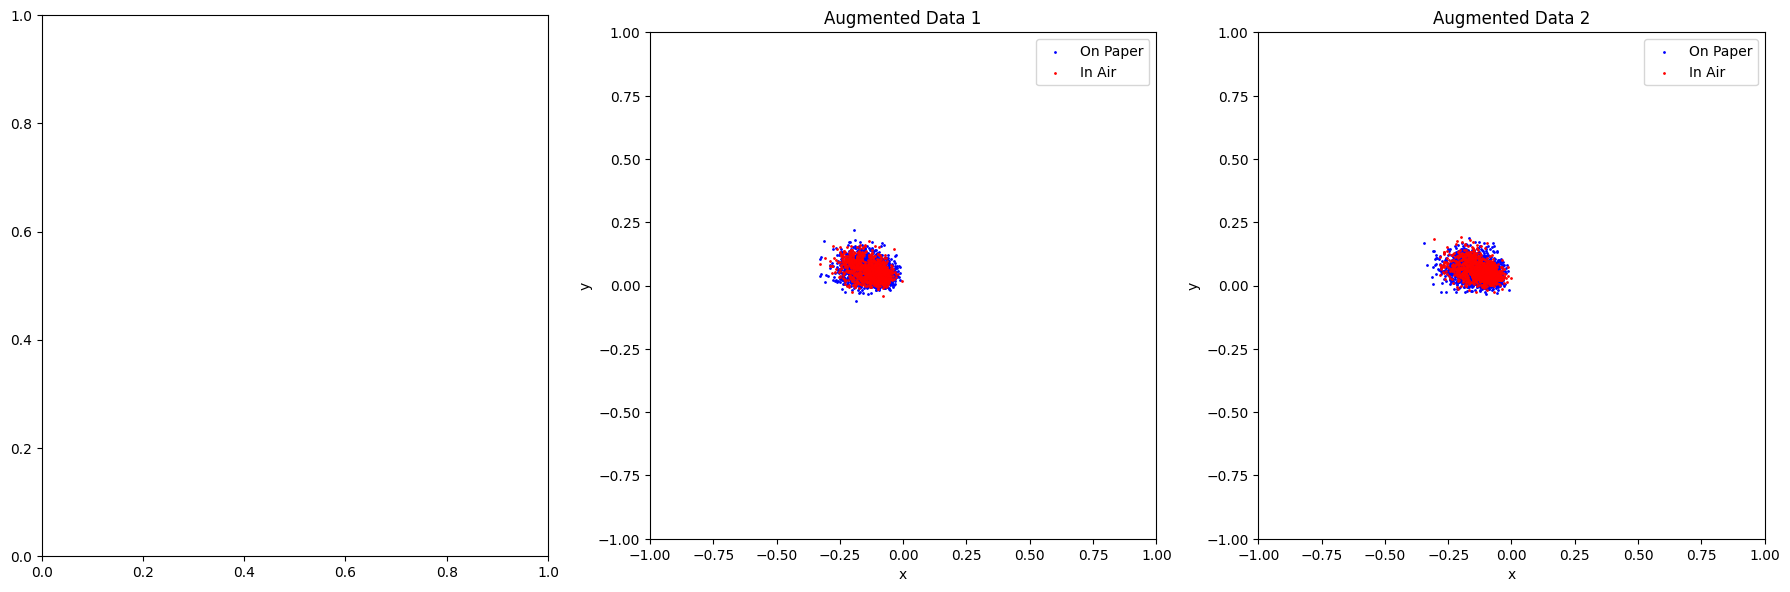


Epoch 5/500 started. Processing 4 batches...


Epoch 5/500:   0%|          | 0/4 [00:00<?, ?batch/s]

Starting train_step with input x shape: [512 2 3]
Losses - Total Loss: 0.374432206 VAE Loss: 0.372413814 KL Loss: 0.0249903984 Generator Loss: 0.628132939 Discriminator Loss: 1.39025414
Gradients before clipping: [0.000604562694,
 3.88567241e-05,
 5.09227211e-05,
 0.00040552608,
 3.67597531e-05,
 0.000100968493,
 0.000449363957,
 4.32125853e-05,
 0.000240110036,
 0.000678552315,
 0.000771195395,
 0.00925058778,
 0.000593719829,
 0.0131814871,
 0.000692223955,
 0.00131400139,
 0.0131110558,
 0.000815696956,
 0.00865211058,
 0.00598332379,
 0.0247542448,
 4.73418368e-05,
 3.76587582e-06,
 6.73200848e-05,
 3.75184281e-05,
 4.09618542e-06,
 0.000195427303,
 2.88995452e-05,
 0.00037330389,
 5.43901624e-05,
 0.0003986886]
Gradients after clipping: [0.000604562694,
 3.88567241e-05,
 5.09227211e-05,
 0.00040552608,
 3.67597531e-05,
 0.000100968493,
 0.000449363957,
 4.32125853e-05,
 0.000240110036,
 0.000678552315,
 0.000771195395,
 0.00925058778,
 0.000593719829,
 0.0131814871,
 0.00069222395

Epoch 5/500:  25%|██▌       | 1/4 [00:00<00:01,  2.64batch/s, Total=0.374, VAE=0.372, KL=0.025, G=0.628, D=1.39]

Starting train_step with input x shape: [512 2 3]
Losses - Total Loss: 0.364153147 VAE Loss: 0.362139106 KL Loss: 0.0292216074 Generator Loss: 0.62323606 Discriminator Loss: 1.39080715
Gradients before clipping: [0.000648411224,
 4.20369142e-05,
 6.13272859e-05,
 0.000420214375,
 4.05067804e-05,
 0.000120642719,
 0.000480336079,
 4.83143085e-05,
 0.000296292,
 0.000717531075,
 0.000854612503,
 0.00862035062,
 0.000726499537,
 0.0103333304,
 0.000598525163,
 0.00167582184,
 0.0105713885,
 0.00069122063,
 0.0107528111,
 0.00546331,
 0.0306200944,
 4.8667589e-05,
 3.86776128e-06,
 6.72345559e-05,
 3.82134276e-05,
 4.32150091e-06,
 0.000193222178,
 3.04077967e-05,
 0.000367392902,
 5.74502e-05,
 0.00039069535]
Gradients after clipping: [0.000648411224,
 4.20369142e-05,
 6.13272859e-05,
 0.000420214375,
 4.05067804e-05,
 0.000120642719,
 0.000480336079,
 4.83143085e-05,
 0.000296292,
 0.000717531075,
 0.000854612503,
 0.00862035062,
 0.000726499537,
 0.0103333304,
 0.000598525163,
 0.001675

Epoch 5/500:  50%|█████     | 2/4 [00:00<00:00,  3.09batch/s, Total=0.364, VAE=0.362, KL=0.0292, G=0.623, D=1.39]

Starting train_step with input x shape: [512 2 3]
Losses - Total Loss: 0.377811462 VAE Loss: 0.375802606 KL Loss: 0.0330153853 Generator Loss: 0.617480755 Discriminator Loss: 1.39138556
Gradients before clipping: [0.00078316452,
 5.07153709e-05,
 9.09420851e-05,
 0.00047993497,
 4.65433586e-05,
 0.00016732722,
 0.000534032239,
 4.98753725e-05,
 0.000375935866,
 0.000766856829,
 0.000957527198,
 0.00894566346,
 0.00079193979,
 0.0120108407,
 0.000631324132,
 0.00217892649,
 0.0117546096,
 0.000912129704,
 0.00991618168,
 0.00621647155,
 0.0138879521,
 4.73530381e-05,
 3.87277214e-06,
 6.68390639e-05,
 3.81937061e-05,
 4.58469458e-06,
 0.000190344406,
 3.22591259e-05,
 0.000360243284,
 6.08007977e-05,
 0.000381204212]
Gradients after clipping: [0.00078316452,
 5.07153709e-05,
 9.09420851e-05,
 0.00047993497,
 4.65433586e-05,
 0.00016732722,
 0.000534032239,
 4.98753725e-05,
 0.000375935866,
 0.000766856829,
 0.000957527198,
 0.00894566346,
 0.00079193979,
 0.0120108407,
 0.000631324132,


Epoch 5/500:  75%|███████▌  | 3/4 [00:00<00:00,  3.43batch/s, Total=0.378, VAE=0.376, KL=0.033, G=0.617, D=1.39] 

Starting train_step with input x shape: [157 2 3]
Losses - Total Loss: 0.376238912 VAE Loss: 0.374235034 KL Loss: 0.0369496755 Generator Loss: 0.614079595 Discriminator Loss: 1.38980162
Gradients before clipping: [0.000842201232,
 5.48773496e-05,
 0.000196185531,
 0.000493499741,
 4.90246675e-05,
 0.000385388761,
 0.000545684248,
 4.97312649e-05,
 0.000875164231,
 0.000783635187,
 0.00182472484,
 0.0148666641,
 0.00151868712,
 0.0186445303,
 0.00113583507,
 0.00414109277,
 0.0201887805,
 0.00167505257,
 0.0203764718,
 0.0117365448,
 0.0358323045,
 4.75182569e-05,
 3.96665928e-06,
 6.69675355e-05,
 3.88580956e-05,
 4.87221132e-06,
 0.000188786624,
 3.41754094e-05,
 0.000355215278,
 6.43262538e-05,
 0.000374458265]
Gradients after clipping: [0.000842201232,
 5.48773496e-05,
 0.000196185531,
 0.000493499741,
 4.90246675e-05,
 0.000385388761,
 0.000545684248,
 4.97312649e-05,
 0.000875164231,
 0.000783635187,
 0.00182472484,
 0.0148666641,
 0.00151868712,
 0.0186445303,
 0.00113583507,
 0.

Epoch 5/500: 100%|██████████| 4/4 [00:01<00:00,  3.67batch/s, Total=0.376, VAE=0.374, KL=0.0369, G=0.614, D=1.39]


Epoch 5/500 completed. Total Loss: 0.3732, Vae Loss: 0.3711, Kl Loss: 0.0310, G Loss: 0.6207, D Loss: 1.3906
New best loss achieved. Patience counter reset.
Generating and visualizing augmented data...


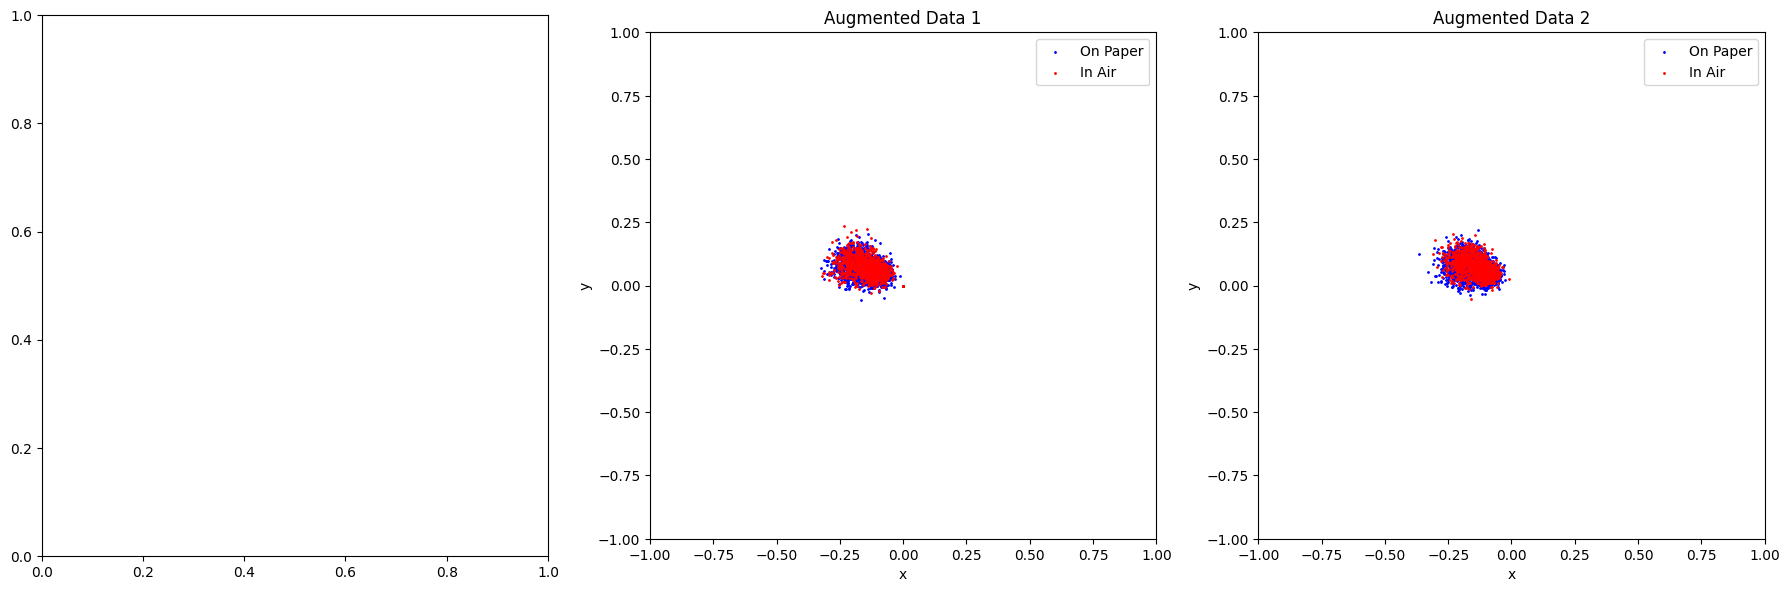


Epoch 6/500 started. Processing 4 batches...


Epoch 6/500:   0%|          | 0/4 [00:00<?, ?batch/s]

Starting train_step with input x shape: [512 2 3]
Losses - Total Loss: 0.374402076 VAE Loss: 0.372401923 KL Loss: 0.0419899598 Generator Loss: 0.608355701 Discriminator Loss: 1.39179015
Gradients before clipping: [0.000946553715,
 6.24792374e-05,
 0.000122877856,
 0.000536190171,
 5.78740292e-05,
 0.000214411353,
 0.000614879711,
 6.0755021e-05,
 0.000463602948,
 0.000864406582,
 0.00111132662,
 0.00819039717,
 0.000973199611,
 0.0125222495,
 0.000708942418,
 0.00257528527,
 0.0137274079,
 0.00113175635,
 0.0140630901,
 0.00791955367,
 0.02292151,
 4.73047912e-05,
 3.93903474e-06,
 6.67054701e-05,
 3.82967337e-05,
 5.00437727e-06,
 0.00018614452,
 3.50748705e-05,
 0.000349709648,
 6.62825842e-05,
 0.000365584274]
Gradients after clipping: [0.000946553715,
 6.24792374e-05,
 0.000122877856,
 0.000536190171,
 5.78740292e-05,
 0.000214411353,
 0.000614879711,
 6.0755021e-05,
 0.000463602948,
 0.000864406582,
 0.00111132662,
 0.00819039717,
 0.000973199611,
 0.0125222495,
 0.000708942418,
 

Epoch 6/500:  25%|██▌       | 1/4 [00:00<00:01,  2.48batch/s, Total=0.374, VAE=0.372, KL=0.042, G=0.608, D=1.39]

Starting train_step with input x shape: [512 2 3]
Losses - Total Loss: 0.378149152 VAE Loss: 0.37615186 KL Loss: 0.0494268835 Generator Loss: 0.602916479 Discriminator Loss: 1.39437723
Gradients before clipping: [0.00107206055,
 7.32946719e-05,
 8.24273229e-05,
 0.000599253224,
 7.1686467e-05,
 0.000124750979,
 0.000729352818,
 7.99895788e-05,
 0.000219199472,
 0.00105051161,
 0.000668039254,
 0.00889511127,
 0.000494545326,
 0.0126682706,
 0.000654508243,
 0.000654931762,
 0.0131723024,
 0.000888040813,
 0.00304820761,
 0.00679096533,
 0.014204694,
 4.71313433e-05,
 3.8992157e-06,
 6.66856067e-05,
 3.7298727e-05,
 5.06872084e-06,
 0.000183972326,
 3.5176552e-05,
 0.00034369,
 6.74063704e-05,
 0.0003574437]
Gradients after clipping: [0.00107206055,
 7.32946719e-05,
 8.24273229e-05,
 0.000599253224,
 7.1686467e-05,
 0.000124750979,
 0.000729352818,
 7.99895788e-05,
 0.000219199472,
 0.00105051161,
 0.000668039254,
 0.00889511127,
 0.000494545326,
 0.0126682706,
 0.000654508243,
 0.00065

Epoch 6/500:  50%|█████     | 2/4 [00:00<00:00,  2.58batch/s, Total=0.378, VAE=0.376, KL=0.0494, G=0.603, D=1.39]

Starting train_step with input x shape: [512 2 3]
Losses - Total Loss: 0.376831144 VAE Loss: 0.374839127 KL Loss: 0.0554435365 Generator Loss: 0.598240674 Discriminator Loss: 1.3937819
Gradients before clipping: [0.00115992525,
 8.03004223e-05,
 9.43748892e-05,
 0.000627384579,
 7.87369936e-05,
 0.000148031817,
 0.000776087516,
 8.6540429e-05,
 0.000275097409,
 0.00112440123,
 0.000797472487,
 0.00902655441,
 0.000611842261,
 0.0111991521,
 0.000586538401,
 0.00117072428,
 0.0113781793,
 0.000782618183,
 0.0058275233,
 0.00587849738,
 0.0148996133,
 4.83879739e-05,
 4.06806384e-06,
 6.6487e-05,
 3.85081403e-05,
 5.35366144e-06,
 0.000181280877,
 3.71008537e-05,
 0.000336715049,
 7.0717113e-05,
 0.000348816044]
Gradients after clipping: [0.00115992525,
 8.03004223e-05,
 9.43748892e-05,
 0.000627384579,
 7.87369936e-05,
 0.000148031817,
 0.000776087516,
 8.6540429e-05,
 0.000275097409,
 0.00112440123,
 0.000797472487,
 0.00902655441,
 0.000611842261,
 0.0111991521,
 0.000586538401,
 0.00

Epoch 6/500:  75%|███████▌  | 3/4 [00:01<00:00,  2.91batch/s, Total=0.377, VAE=0.375, KL=0.0554, G=0.598, D=1.39]

Starting train_step with input x shape: [157 2 3]
Losses - Total Loss: 0.381326318 VAE Loss: 0.379335046 KL Loss: 0.0626109689 Generator Loss: 0.59127295 Discriminator Loss: 1.3999927
Gradients before clipping: [0.00133447116,
 9.39166493e-05,
 0.000150958556,
 0.000698653515,
 9.38012745e-05,
 0.000253608072,
 0.000889885239,
 0.000105018829,
 0.000518633635,
 0.00129189389,
 0.00157461804,
 0.015357133,
 0.00129502697,
 0.0220041405,
 0.00123089179,
 0.00297233113,
 0.0245383326,
 0.00175861979,
 0.0213095956,
 0.0133565683,
 0.047510203,
 4.12115187e-05,
 3.5072851e-06,
 6.63115861e-05,
 3.32223353e-05,
 5.12191627e-06,
 0.000178858332,
 3.50531882e-05,
 0.000329094793,
 6.88750224e-05,
 0.000339746388]
Gradients after clipping: [0.00133447116,
 9.39166493e-05,
 0.000150958556,
 0.000698653515,
 9.38012745e-05,
 0.000253608072,
 0.000889885239,
 0.000105018829,
 0.000518633635,
 0.00129189389,
 0.00157461804,
 0.015357133,
 0.00129502697,
 0.0220041405,
 0.00123089179,
 0.0029723311

Epoch 6/500: 100%|██████████| 4/4 [00:01<00:00,  3.15batch/s, Total=0.381, VAE=0.379, KL=0.0626, G=0.591, D=1.4] 

Epoch 6/500 completed. Total Loss: 0.3777, Vae Loss: 0.3757, Kl Loss: 0.0524, G Loss: 0.6002, D Loss: 1.3950
No improvement. Patience counter: 1/50
Generating and visualizing augmented data...


KeyboardInterrupt: 

In [21]:
# Cell 6 (modified)
def pad_sequences(data, target_length):
    """Pad sequences to target length."""
    current_length = data.shape[0]
    if current_length >= target_length:
        return data[:target_length]
    else:
        padding = np.zeros((target_length - current_length, data.shape[1]))
        return np.vstack([data, padding])

def create_sequences(data, seq_length):
    """Create sequences from data."""
    sequences = []
    for i in range(0, len(data) - seq_length + 1, seq_length):
        seq = data[i:i+seq_length]
        if len(seq) == seq_length:
            sequences.append(seq)
    return np.array(sequences)

# Updated train_step function with detailed tf.print statements
@tf.function
def train_step(vaegan, x, optimizer):
    tf.print("Starting train_step with input x shape:", tf.shape(x))
    
    with tf.GradientTape() as tape:
        total_loss, vae_loss, kl_loss, g_loss, d_loss = compute_loss(vaegan, x)
        
        # Print computed losses in detail
        tf.print("Losses - Total Loss:", total_loss, 
                 "VAE Loss:", vae_loss, "KL Loss:", kl_loss, 
                 "Generator Loss:", g_loss, "Discriminator Loss:", d_loss)

    # Compute gradients and print their norms
    gradients = tape.gradient(total_loss, vaegan.trainable_variables)
    tf.print("Gradients before clipping:", [tf.norm(grad) for grad in gradients if grad is not None])

    # Clip gradients to prevent exploding gradients
    clipped_gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
    tf.print("Gradients after clipping:", [tf.norm(grad) for grad in clipped_gradients if grad is not None])
    
    # Apply gradients
    optimizer.apply_gradients(zip(clipped_gradients, vaegan.trainable_variables))
    tf.print("Gradients applied successfully.")

    return total_loss, vae_loss, kl_loss, g_loss, d_loss

# Training loop remains the same
batch_size = 512
seq_length = 2

sequences = create_sequences(combined_data, seq_length)
train_dataset = tf.data.Dataset.from_tensor_slices(sequences).shuffle(10000).batch(batch_size)

epochs = 500
early_stopping_patience = 50
min_delta = 0.0001
best_loss = float('inf')
patience_counter = 0

loss_history = {'total': [], 'vae': [], 'kl': [], 'g': [], 'd': []}

for epoch in range(epochs):
    epoch_losses = {'total': 0, 'vae': 0, 'kl': 0, 'g': 0, 'd': 0}
    num_batches = len(train_dataset)
    
    print(f"\nEpoch {epoch + 1}/{epochs} started. Processing {num_batches} batches...")

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for i, batch in enumerate(train_dataset):
            losses = train_step(vaegan, batch, optimizer)
            for key, value in zip(['total', 'vae', 'kl', 'g', 'd'], losses):
                epoch_losses[key] += value
            pbar.update(1)
            pbar.set_postfix({k: float(v) for k, v in zip(['Total', 'VAE', 'KL', 'G', 'D'], losses)})

    # Calculate and print average losses for the epoch
    avg_losses = {k: v / num_batches for k, v in epoch_losses.items()}
    for k, v in avg_losses.items():
        loss_history[k].append(v)

    print(f"Epoch {epoch+1}/{epochs} completed. " +
          ', '.join([f'{k.capitalize()} Loss: {v:.4f}' for k, v in avg_losses.items()]))

    # Early stopping logic
    if avg_losses['total'] < best_loss - min_delta:
        best_loss = avg_losses['total']
        patience_counter = 0
        print("New best loss achieved. Patience counter reset.")
    else:
        patience_counter += 1
        print(f"No improvement. Patience counter: {patience_counter}/{early_stopping_patience}")

    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered.")
        break

    # Data generation and visualization
    if (epoch + 1) % 1 == 0:
        print("Generating and visualizing augmented data...")
        num_augmented_files = 2
        augmented_datasets_vaegan = generate_augmented_data_vaegan(vaegan, num_augmented_files, avg_data_points)

        # Visualize the original and augmented data side by side
        fig, axs = plt.subplots(1, num_augmented_files + 1, figsize=(6 * (num_augmented_files + 1), 6))
        original_on_paper = combined_data[combined_data[:, 2] == 1]
        original_in_air = combined_data[combined_data[:, 2] == 0]
        # axs[0].scatter(original_on_paper[:, 0], original_on_paper[:, 1], c='b', s=1, label='On Paper')
        # axs[0].scatter(original_in_air[:, 0], original_in_air[:, 1], c='r', s=1, label='In Air')
        # axs[0].set_xlabel('x')
        # axs[0].set_ylabel('y')
        # axs[0].set_aspect('equal')
        # axs[0].legend()

        # Set consistent axis limits for square aspect ratio
        x_min, x_max = -1, 1  # Set to -1 and 1 due to new scaling
        y_min, y_max = -1, 1  # Set to -1 and 1 due to new scaling

        for i, augmented_data in enumerate(augmented_datasets_vaegan):
            augmented_on_paper = augmented_data[augmented_data[:, 2] > 0.5]
            augmented_in_air = augmented_data[augmented_data[:, 2] <= 0.5]
            axs[i + 1].scatter(augmented_on_paper[:, 0], augmented_on_paper[:, 1], c='b', s=1, label='On Paper')
            axs[i + 1].scatter(augmented_in_air[:, 0], augmented_in_air[:, 1], c='r', s=1, label='In Air')
            axs[i + 1].set_title(f'Augmented Data {i + 1}')
            axs[i + 1].set_xlabel('x')
            axs[i + 1].set_ylabel('y')
            axs[i + 1].set_aspect('equal')
            axs[i + 1].set_xlim(x_min, x_max)
            axs[i + 1].set_ylim(y_min, y_max)
            axs[i + 1].legend()

        plt.tight_layout()
        plt.show()

plt.figure(figsize=(12, 8))
for key, values in loss_history.items():
    plt.plot(values, label=key.capitalize())
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.show()

In [51]:
# Cell 7 (modified)
def download_augmented_data(augmented_datasets, scalers, directory='augmented_data'):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for i, (augmented_data, scaler) in enumerate(zip(augmented_datasets, scalers)):
        # Inverse transform the x and y coordinates
        augmented_data_original_scale = np.column_stack((
            scaler.inverse_transform(augmented_data[:, :2]),
            augmented_data[:, 2]
        ))
        
        # Round to whole numbers and ensure pen_status is binary
        augmented_data_original_scale[:, :2] = np.round(augmented_data_original_scale[:, :2])
        augmented_data_original_scale[:, 2] = np.round(augmented_data_original_scale[:, 2]).astype(int)
        
        filename = os.path.join(directory, f'augmented_data_{i+1}.csv')
        pd.DataFrame(augmented_data_original_scale, columns=['x', 'y', 'pen_status']).to_csv(filename, index=False)
        print(f"Saved {filename}")

download_augmented_data(augmented_datasets_vaegan, scalers[:len(augmented_datasets_vaegan)])

Saved augmented_data\augmented_data_1.csv
